# **Preparing dataset**

In [74]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [75]:
CAT_LABEL = 3
DOG_LABEL = 5
TARGET_CLASSES = [CAT_LABEL, DOG_LABEL]

class CIFAR10Custom(Dataset):
    def __init__(self, data_path, is_train=True, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        batches = [f"data_batch_{i}" for i in range(1, 6)] if is_train else ["test_batch"]

        for batch_name in batches:
            batch_path = os.path.join(data_path, batch_name)
            with open(batch_path, 'rb') as f:
                batch = pickle.load(f, encoding='bytes')
                imgs = batch[b'data']
                labels = batch[b'labels']
                imgs = imgs.reshape(-1, 3, 32, 32)

                for img, label in zip(imgs, labels):
                    if label in TARGET_CLASSES:
                        self.data.append(img)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx].astype(np.uint8)
        img = torch.tensor(img, dtype=torch.float32) / 255.0  
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

def get_cat_dog_loaders_kaggle(batch_size=64):
    transform = transforms.Normalize((0.5,), (0.5,))
    dataset_path = "../input/cifar10-dataset/cifar-10-batches-py"

    train_dataset = CIFAR10Custom(dataset_path, is_train=True, transform=transform)
    test_dataset = CIFAR10Custom(dataset_path, is_train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [76]:
train_loader, test_loader = get_cat_dog_loaders_kaggle(batch_size=64)
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)  
print("Labels:", labels[:10])

Batch shape: torch.Size([64, 3, 32, 32])
Labels: tensor([3, 5, 3, 3, 5, 5, 5, 5, 5, 3])


# **Building Custom GAN **

**Generator:**

In [77]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim=100, image_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

**Mini Batch Discrimination**

In [78]:
import torch
import torch.nn as nn

class MiniBatchDiscrimination(nn.Module):
    def __init__(self, in_features, out_features, kernel_dims):
        super(MiniBatchDiscrimination, self).__init__()
        self.out_features = out_features
        self.kernel_dims = kernel_dims

        self.T = nn.Parameter(torch.randn(in_features, out_features, kernel_dims))

    def forward(self, x):
        M = x @ self.T.view(x.size(1), -1)
        M = M.view(-1, self.out_features, self.kernel_dims)

        out = []
        for i in range(M.size(0)):
            diff = M[i].unsqueeze(0) - M
            abs_diff = torch.abs(diff).sum(2)
            exp_neg = torch.exp(-abs_diff)
            out.append(exp_neg.sum(0) - 1)  # exclude self

        out = torch.stack(out)
        return torch.cat([x, out], dim=1)

**Discriminator:**

In [79]:
class Discriminator(nn.Module):
    def __init__(self, image_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()

        self.embedding = nn.Sequential(
            nn.Conv2d(image_channels, feature_maps, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        self.mb_disc = MiniBatchDiscrimination(in_features=feature_maps * 4 * 4 * 4, out_features=100, kernel_dims=5)

        self.similarity = nn.Sequential(
            nn.Linear((feature_maps * 4 * 4 * 4 + 100) * 2, 512), 
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        emb1 = self.embedding(img1)
        emb2 = self.embedding(img2)

        emb1 = self.mb_disc(emb1)
        emb2 = self.mb_disc(emb2)

        combined = torch.cat([emb1, emb2], dim=1)
        return self.similarity(combined)

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)

**Training**

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import os

In [82]:
criterion = nn.BCELoss()
lr = 2e-4
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [83]:
G_losses = []
D_losses = []
epochs = 50
noise_dim = 100
fixed_noise = torch.randn(16, noise_dim, 1, 1, device=device)

os.makedirs("images", exist_ok=True)

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)

        # Train Discriminator
        D.zero_grad()

        # Fake images
        noise = torch.randn(real_images.size(0), noise_dim, 1, 1, device=device)
        fake_images = G(noise)

        # Labels
        real_label = torch.zeros((real_images.size(0), 1), device=device) 
        fake_label = torch.ones((real_images.size(0), 1), device=device)  

        # Similarity score between real and fake
        D_output = D(real_images, fake_images.detach())
        D_loss = criterion(D_output, fake_label)  
        D_loss.backward()
        D_optimizer.step()

        # Train Generator
        G.zero_grad()

        G_output = D(real_images, fake_images)
        G_loss = criterion(G_output, real_label)  
        G_loss.backward()
        G_optimizer.step()

        D_losses.append(D_loss.item())
        G_losses.append(G_loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] Batch [{i}/{len(train_loader)}] "
                  f"D Loss: {D_loss.item():.4f}, G Loss: {G_loss.item():.4f}")

    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
        vutils.save_image(fake, f"images/fake_epoch_{epoch}.png", normalize=True)

Epoch [0/50] Batch [0/157] D Loss: 0.6950, G Loss: 4.1565
Epoch [0/50] Batch [100/157] D Loss: 0.0001, G Loss: 9.6899
Epoch [1/50] Batch [0/157] D Loss: 0.0000, G Loss: 10.4366
Epoch [1/50] Batch [100/157] D Loss: 0.0000, G Loss: 11.6326
Epoch [2/50] Batch [0/157] D Loss: 0.0000, G Loss: 12.1170
Epoch [2/50] Batch [100/157] D Loss: 0.0000, G Loss: 12.7840
Epoch [3/50] Batch [0/157] D Loss: 0.0000, G Loss: 13.2558
Epoch [3/50] Batch [100/157] D Loss: 0.0000, G Loss: 13.6502
Epoch [4/50] Batch [0/157] D Loss: 0.0000, G Loss: 13.8978
Epoch [4/50] Batch [100/157] D Loss: 0.0000, G Loss: 14.1559
Epoch [5/50] Batch [0/157] D Loss: 0.0000, G Loss: 14.2759
Epoch [5/50] Batch [100/157] D Loss: 0.0000, G Loss: 14.4197
Epoch [6/50] Batch [0/157] D Loss: 0.0000, G Loss: 14.5764
Epoch [6/50] Batch [100/157] D Loss: 0.0000, G Loss: 14.8217
Epoch [7/50] Batch [0/157] D Loss: 0.0000, G Loss: 14.9816
Epoch [7/50] Batch [100/157] D Loss: 0.0000, G Loss: 15.0692
Epoch [8/50] Batch [0/157] D Loss: 0.0000,

# **VAE**

**Encoder:**

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 64x8x8
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   # 3x32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


**Training**

In [85]:
vae_losses = []
vae = VAE(latent_dim=128).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

def vae_loss_fn(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae.train()
epochs = 50

for epoch in range(epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        recon, mu, logvar = vae(images)
        loss = vae_loss_fn(recon, images, mu, logvar)

        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()

        vae_losses.append(loss.item()) 

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - VAE Loss: {total_loss:.2f}")

Epoch [1/50] - VAE Loss: 8487338.65
Epoch [2/50] - VAE Loss: 6772581.59
Epoch [3/50] - VAE Loss: 6506724.84
Epoch [4/50] - VAE Loss: 6335142.27
Epoch [5/50] - VAE Loss: 6210728.48
Epoch [6/50] - VAE Loss: 6145285.99
Epoch [7/50] - VAE Loss: 6102066.17
Epoch [8/50] - VAE Loss: 6067243.19
Epoch [9/50] - VAE Loss: 6039640.16
Epoch [10/50] - VAE Loss: 6024501.52
Epoch [11/50] - VAE Loss: 6008209.92
Epoch [12/50] - VAE Loss: 5998530.48
Epoch [13/50] - VAE Loss: 5988897.96
Epoch [14/50] - VAE Loss: 5980925.98
Epoch [15/50] - VAE Loss: 5973985.68
Epoch [16/50] - VAE Loss: 5968608.24
Epoch [17/50] - VAE Loss: 5963999.79
Epoch [18/50] - VAE Loss: 5959497.29
Epoch [19/50] - VAE Loss: 5955435.74
Epoch [20/50] - VAE Loss: 5951033.15
Epoch [21/50] - VAE Loss: 5946615.99
Epoch [22/50] - VAE Loss: 5944257.83
Epoch [23/50] - VAE Loss: 5941543.93
Epoch [24/50] - VAE Loss: 5940050.00
Epoch [25/50] - VAE Loss: 5937359.58
Epoch [26/50] - VAE Loss: 5933912.58
Epoch [27/50] - VAE Loss: 5933131.47
Epoch [28/

**Generate images using VAE**

In [86]:
vae.eval()
with torch.no_grad():
    z = torch.randn(16, 128).to(device)
    samples = vae.decode(z).cpu()
    vutils.save_image(samples, "vae_samples.png", normalize=True)

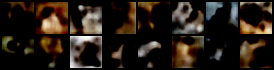

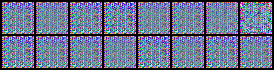

In [87]:
from IPython.display import Image, display
display(Image(filename="vae_samples.png"))
display(Image(filename="images/fake_epoch_49.png"))

**Comparison**

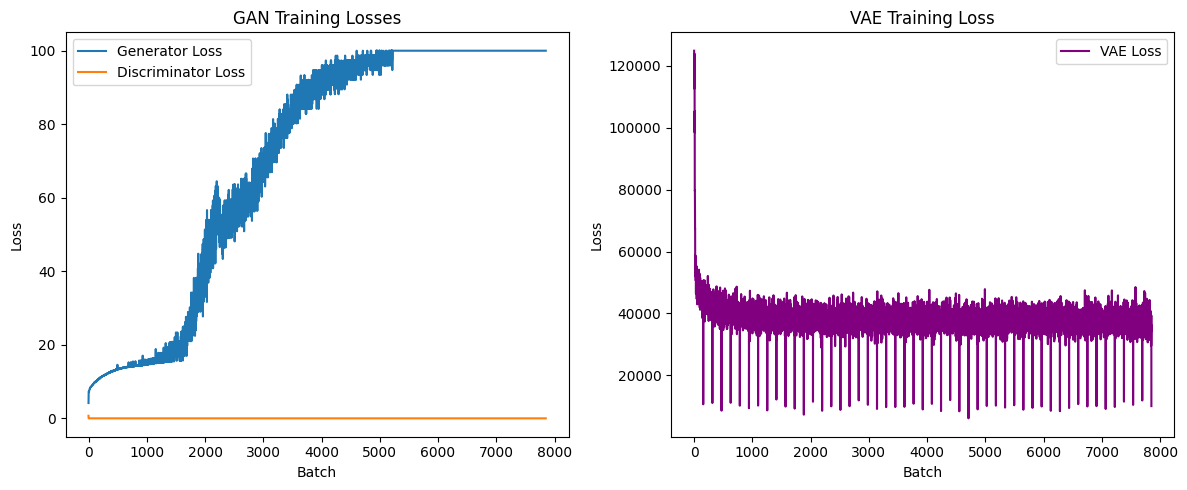

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.title("GAN Training Losses")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(vae_losses, label="VAE Loss", color='purple')
plt.title("VAE Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2

In [90]:
real_np = images[0].permute(1, 2, 0).cpu().numpy()
fake_np = fake[0].permute(1, 2, 0).cpu().numpy()
real_gray = cv2.cvtColor((real_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
fake_gray = cv2.cvtColor((fake_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
score = ssim(real_gray, fake_gray)
print(f"SSIM between real and generated: {score:.4f}")

SSIM between real and generated: 0.0492
